# Split polygon
The objective of this notebook is to devise a method for creating an array of somewhat equaly spaced points inside of a polygon.

In [1]:
import numpy as np
from skimage import draw, io
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

## Strategy - Physics
The first approach is to run a physics simulation to make the points relax maximizing the distances beteween them. We start with an array of random points

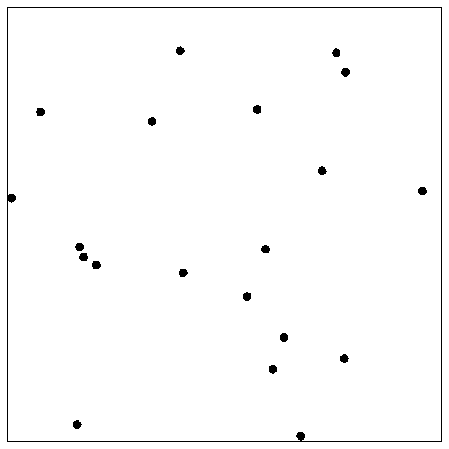

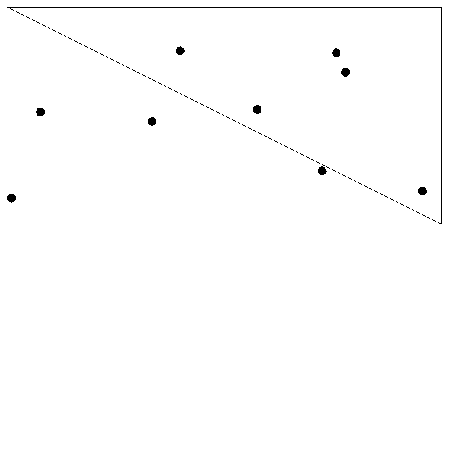

In [2]:
def draw_polygon(img, polygon):
    max_y = max([p[0] for p in polygon]) + 1
    max_x = max([p[1] for p in polygon]) + 1
    rs, cs = zip(*polygon)
    rr, cc = draw.polygon_perimeter(rs, cs, [max_y, max_x])
    img[rr, cc,:] = [0, 0, 0]
    
def plot_points(img, points, polygon=None, show=True, save=None):
    max_y = max([p[0] for p in polygon]) + 1
    max_x = max([p[1] for p in polygon]) + 1

    for p in points:
        rr, cc = draw.circle(*p, 6, [max_y, max_x])
        img[rr, cc,:] = [0, 0, 0]
    if polygon:
        draw_polygon(img, polygon)
    if save:
        io.imsave(save, img.astype(np.uint8), check_contrast=False)
    if show:
        fig = plt.figure(figsize=(8, 8))
        plt.axis('off')
        plt.imshow(img)


size = 600
N = 20
points = np.random.rand(N, 2) * (size-1)
rectangle = [
    [0, 0], 
    [0, size-1], 
    [size-1, size-1], 
    [size-1, 0], 
    [0, 0]
]
triangle = [
    [0, 0], 
    [0, size-1], 
    [size//2-1, size-1], 
    [0, 0]
]
img = np.ones([size, size, 3],dtype=np.uint8) * 255
plot_points(img, points, rectangle, True, "random_rectangle.png")
img = np.ones([size, size, 3],dtype=np.uint8) * 255
plot_points(img, points, triangle, True, "random_triangle.png")

Then we calculate forces between the points and also add a force relative to the walls. We add momentum, drag an viscosity to accelerate the convergence.

In [3]:
def relax_points(
        points, 
        momentum, 
        base_force, 
        drag,
        viscosity,
        boundary_fn,
        boundary_fn_args,
        boundary,
    ):
    p = points.copy()
    m = momentum.copy()
    
    # Calculate forces
    N = len(points)
    points_forces = compute_point_forces(p)
    boundary_forces = boundary_fn(
        p, *boundary_fn_args).reshape((N, 1, 2))
    final_forces = np.concatenate(
        [points_forces, boundary_forces],
        axis=1
    ).sum(axis=1)
    
    # Final momentum
    m += final_forces * base_force
    
    # Add friction and limit momentum
    m_modulus = np.linalg.norm(m, axis=1).reshape((-1, 1))
    m_direction = m/m_modulus
    m_modulus -= drag * m_modulus**2
    m_modulus[m_modulus<=viscosity] /= 10
    m_modulus[m_modulus<=0] = 1  # Make things a little sticky
    m = m_modulus * m_direction
    
    
    # Prevent points from going out of bounds
    outbounds = ~check_inbounds(p + m, boundary)
    m[outbounds] = 0
    m[outbounds] = 0
    
    # Move points
    dp = m.copy()
    dp[dp > 2] = 2
    p += dp
    return p, m


def compute_point_forces(points):
    forces = []
    for p1 in points:
        distances = points - p1
        distance_norm = np.linalg.norm(distances, axis=1).reshape((-1, 1))
        distance_norm[distance_norm == 0] = np.inf
        force_direction = distances/distance_norm
        forces.append(force_direction/distance_norm**2)
    return -np.array(forces)


def compute_wall_forces(points, wall):
    # Outer wall force
    outer_dist = points - wall
    outer_dist[outer_dist == 0] = np.inf
    outer_force = -1/(outer_dist**2)
    # Inner wall force
    inner_dist = points
    inner_dist[inner_dist == 0] = np.inf
    inner_force = 1/(inner_dist**2)
    return inner_force + outer_force


def check_inbounds(points, poly):
    #  TODO - vectorize this
    inbound = []
    for x, y in points:
        c = False
        for (ppx, ppy), (pnx, pny) in zip(poly[1:], poly):
            if ((pny > y) != (ppy > y)) and \
                (x < pnx + (ppx - pnx) * 
                 (y - pny) / (ppy - pny)):
                c = not c
        inbound.append(c)
    return np.array(inbound)


def build_animation(
        points, 
        base_force,
        drag,
        viscosity,
#         heat_loss,
        iterations,
        boundary_fn,
        boundary_fn_args,
        boundary,
        output_name,
    ):
    N = len(points)
    p, m = points.copy(), np.zeros((N, 2))
    !rm -f points/*
    
    min_y = min([b[0] for b in boundary])
    max_y = max([b[0] for b in boundary])
    min_x = min([b[1] for b in boundary])
    max_x = max([b[1] for b in boundary])
    
    width = np.ceil(max_x - min_x + 1).astype(np.uint16)
    height = np.ceil(max_y - min_y + 1).astype(np.uint16)
    for i in trange(iterations, desc="building frames"):
        p, m = relax_points(
            p, 
            m, 
            base_force, 
#             drag * heat_loss ** i,
            drag,
            viscosity,
            boundary_fn, 
            boundary_fn_args,
            boundary,
        )
        img = np.ones([height, width, 3],dtype=np.uint8) * 255
        plot_points(img, p, boundary, False, f"points/frame_{str(i).zfill(4)}.png")
    !echo 'building gif:' && gifski -o {output_name} --width {width} points/frame*

N = 20
points = np.random.rand(N, 2) * (size-1)
base_force = size*100
drag = 0.02
viscosity = 0.01
# heat_loss = 1.1
iterations = 240

build_animation(
        points, 
        base_force, 
        drag,
        viscosity,
#         heat_loss,
        iterations,
        compute_wall_forces,
        (size,),
        rectangle,
        f"rectangle_{N}p.gif"
    )

zsh:1: no matches found: points/*



building gif:
gifski created rectangle_20p.gif                                                

![rectangle_20p](rectangle_20p.gif)

In [4]:
N = 100
points = np.random.rand(N, 2) * (size-1)
base_force = size*1
drag = 0.02
viscosity = 0.01
iterations = 600

build_animation(
        points, 
        base_force,
        drag,
        viscosity,
        iterations,
        compute_wall_forces,
        (size,),
        rectangle,
        f"rectangle_{N}p.gif"
    )


building gif:
gifski created rectangle_100p.gif                                               

![rectangle_100p](rectangle_100p.gif)

Then, adding a polygonal boundary we get the following:

In [5]:
def compute_polygon_forces(points, polygon):
    poly_forces = []
    for pt in points:
        # Calculate wall forces
        walls = np.array([distance_pt_line(pt, np.array(v1), np.array(v2)) 
                 for v1, v2 in zip(polygon, polygon[1:])])
        walls_modulus = np.linalg.norm(walls, axis=1).reshape((-1, 1))
        walls_modulus[walls_modulus == 0] = np.inf
        walls_directions = walls/walls_modulus
        wall_forces = walls_directions/(walls_modulus**2)
        
        # Calculate vertex forces
        vertex = np.array([pt - np.array(v) for v in polygon[:-1]])
        vertex_modulus = np.linalg.norm(vertex, axis=1).reshape((-1, 1))
        vertex_modulus[vertex_modulus == 0] = np.inf
        vertex_directions = vertex/vertex_modulus
        vertex_forces = vertex_directions/(vertex_modulus**2)
        poly_forces.append(
            wall_forces.sum(axis=0) +
            vertex_forces.sum(axis=0))
    return -np.array(poly_forces)
        
        
def distance_pt_line(pt, v1, v2):
    """ 
    https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    """
    if all(v1 == pt) or all(v2 == pt):
        return [0, 0]
    if np.arccos(np.dot(
            (pt - v1) / np.linalg.norm(pt - v1), 
            (v2 - v1) / np.linalg.norm(v2 - v1))) > np.pi / 2:
        return -(pt - v1)
    if np.arccos(np.dot(
            (pt - v2) / np.linalg.norm(pt - v2), 
            (v1 - v2) / np.linalg.norm(v1 - v2))) > np.pi / 2:
        return -(pt - v2)
    n = (v1-v2)/np.linalg.norm(v1-v2)
    return (v1-pt) - (np.dot((v1-pt), n))*n


def random_in_polygon(N, polygon):
    points = []
    x_min = min([px for px, py in polygon])
    x_max = max([px for px, py in polygon])
    y_min = min([py for px, py in polygon])
    y_max = max([py for px, py in polygon])
    while len(points) < N:
        px, py = np.random.rand(2)
        px *= x_max - x_min
        px += x_min
        py *= y_max - y_min
        py += y_min
        if check_inbounds([[px, py]], polygon)[0]:
            points.append([px, py])
    return np.array(points)  


base_force = size*10
drag = 0.02
viscosity = 0.02
iterations = 240
N = 25
points = random_in_polygon(N, triangle)
build_animation(
    points, 
    base_force,
    drag,
    viscosity,
    iterations,
    compute_polygon_forces,
    (triangle,),
    triangle,
    f"triangle_{N}p.gif"
)


building gif:
gifski created triangle_25p.gif                                                 

![triangle_25p](triangle_25p.gif)

In [6]:
polygon = [
    [0, 0],
    [500, 20],
    [600, 400],
    [500, 600],
    [400, 500],
    [100, 600],
    [120, 160],
    [10, 10],
]
N = 20
points = random_in_polygon(N, polygon)
build_animation(
    points, 
    base_force, 
    drag,
    viscosity,
    iterations,
    compute_polygon_forces,
    (polygon,),
    polygon,
    f"polygon_poly_{N}p.gif"
)


building gif:
gifski created polygon_poly_20p.gif                                             

![polygon_poly_20p](polygon_poly_20p.gif)

In [7]:
N = 10
points = random_in_polygon(N, polygon)
build_animation(
    points, 
    base_force, 
    drag,
    viscosity,
    iterations,
    compute_polygon_forces,
    (polygon,),
    polygon,
    f"polygon_poly_{N}p.gif"
)


building gif:
gifski created polygon_poly_10p.gif                                             

![polygon_poly_10p](polygon_poly_10p.gif)

In [8]:
N = 30
points = random_in_polygon(N, polygon)
build_animation(
    points, 
    base_force, 
    drag,
    viscosity,
    iterations,
    compute_polygon_forces,
    (polygon,),
    polygon,
    f"polygon_poly_{N}p.gif"
)


building gif:
gifski created polygon_poly_30p.gif                                             

![polygon_poly_30p](polygon_poly_30p.gif)

In [9]:
geoPoints = [[
    {"lat":-22.806057244438897,"id":"AhJGnWW6GIbfpjvPd3Fv","lng":-47.06434536752459},
    {"lng":-47.06424344358202,"id":"Ie3paERCGaSqYLhlt9do","lat":-22.80473691249149},
    {"lng":-47.06357825574633,"lat":-22.804781418271087,"id":"dlW4euSOEf70J5f635I3"},
    {"lng":-47.063647993180716,"lat":-22.806101749787267,"id":"SZ3iMOK1ic7CG9e6v04C"}
], [
    {"lng":-47.06365315667577,"lat":-22.806191708694193,"id":"cdWXCC1i0AV84WUgCgS2"},
    {"lng":-47.065745279707386,"id":"VgpvCmdcrOSetTi1ml3X","lat":-22.80607302781124},
    {"lat":-22.80313521472781,"id":"QoLYLk5idWU3xCiDbImp","lng":-47.065598160057505},
    {"id":"LSuOgpUi7J8j3kRxZeHQ","lat":-22.803266261021946,"lng":-47.063438981800516},{"lng":-47.06360845098712,"lat":-22.80619765802111,"id":"Jso40iNVpFzWuesK7pwL"}
], [
    {"lng":-47.06434536752459,"lat":-22.806057244438897,"id":"AhJGnWW6GIbfpjvPd3Fv"},
    {"lat":-22.80473691249149,"id":"Ie3paERCGaSqYLhlt9do","lng":-47.06424344358202},
    {"lat":-22.804781418271087,"id":"dlW4euSOEf70J5f635I3","lng":-47.06357825574633},
    {"id":"SZ3iMOK1ic7CG9e6v04C","lat":-22.806101749787267,"lng":-47.063647993180716}
], [
    {"lng":-47.06434536752459,"lat":-22.806057244438897,"id":"AhJGnWW6GIbfpjvPd3Fv"},
    {"id":"Ie3paERCGaSqYLhlt9do","lng":-47.06424344358202,"lat":-22.80473691249149},
    {"lat":-22.804781418271087,"id":"dlW4euSOEf70J5f635I3","lng":-47.06357825574633},
    {"lat":-22.806101749787267,"lng":-47.063647993180716,"id":"SZ3iMOK1ic7CG9e6v04C"}
], [
    {"lat":-22.806191708694193,"id":"cdWXCC1i0AV84WUgCgS2","lng":-47.06365315667577},
    {"id":"VgpvCmdcrOSetTi1ml3X","lat":-22.80607302781124,"lng":-47.065745279707386},
    {"lng":-47.065598160057505,"lat":-22.80313521472781,"id":"QoLYLk5idWU3xCiDbImp"},
    {"lng":-47.063438981800516,"lat":-22.803266261021946,"id":"LSuOgpUi7J8j3kRxZeHQ"},{"lat":-22.80619765802111,"id":"Jso40iNVpFzWuesK7pwL","lng":-47.06360845098712}
], [
    {"lng":-47.06434536752459,"lat":-22.806057244438897,"id":"AhJGnWW6GIbfpjvPd3Fv"},
    {"lat":-22.80473691249149,"id":"Ie3paERCGaSqYLhlt9do","lng":-47.06424344358202},
    {"id":"dlW4euSOEf70J5f635I3","lng":-47.06357825574633,"lat":-22.804781418271087},
    {"lat":-22.806101749787267,"id":"SZ3iMOK1ic7CG9e6v04C","lng":-47.063647993180716}
], [
    {"id":"fmSnG2glOqqNHmrhlhrp","lng":-54.856194535549825,"lat":-24.544600819697102},
    {"lng":-54.85802380209798,"lat":-24.542912439236932,"id":"cd86FP4gLB5Nxh2znnce"},
    {"id":"ytjA9hjUinEn6aVugx8A","lat":-24.54410309140282,"lng":-54.85905913477773},
    {"id":"3K0L53o6XBJVjmhFtI1f","lng":-54.859466830547994,"lat":-24.54478624738033},
    {"id":"yAHZftnkNQjnFsstfL7i","lat":-24.545673218507314,"lng":-54.859905614956986},
    {"lng":-54.86025966654695,"id":"LEh9KTgvB9iKadsU5OFW","lat":-24.54660034625811},
    {"id":"XkCHsy5AtCPy5saD848r","lng":-54.86045165303607,"lat":-24.54840753037782}]
]

In [10]:
def build_geo_animation(
        N,
        geo_boundaries,
        output_name,
    ):
    base_force = size*100
    drag = 0.05
    viscosity = 0.02
    iterations = 240
    boundary_fn = compute_polygon_forces
    
    min_lat = min([g["lat"] for g in geo_boundaries])
    max_lat = max([g["lat"] for g in geo_boundaries])
    min_lng = min([g["lng"] for g in geo_boundaries])
    max_lng = max([g["lng"] for g in geo_boundaries])
    width = 25 * N
    delta = width/(max_lng - min_lng) 
    
    polygon = [
        [
            delta*(g["lat"] - min_lat),
            delta*(g["lng"] - min_lng),
            
        ] 
        for g in geo_boundaries
    ]

    origin = [0, 0]
    refvec = [1, 0]
    polygon = list(sorted(polygon, key=lambda x: clockwiseangle_and_distance(x, origin, refvec)))
    polygon.append(polygon[0])
    points = random_in_polygon(N, polygon)
    build_animation(
        points, 
        base_force, 
        drag,
        viscosity,
        iterations,
        boundary_fn,
        (polygon,),
        polygon,
        output_name
    )

import math
def clockwiseangle_and_distance(point, origin, refvec):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

N = 20
idx = 0
build_geo_animation(
    N,
    geoPoints[idx],
    f"geo_{idx}_{N}.gif")


building gif:
gifski created geo_0_20.gif                                                     

![geo_0_20.gif](geo_0_20.gif)

In [11]:
idx = 1
build_geo_animation(
    N,
    geoPoints[idx],
    f"geo_{idx}_{N}.gif")


building gif:
gifski created geo_1_20.gif                                                     

In [12]:
idx = 2
build_geo_animation(
    N,
    geoPoints[idx],
    f"geo_{idx}_{N}.gif")


building gif:
gifski created geo_2_20.gif                                                     

In [13]:
idx = 3
build_geo_animation(
    N,
    geoPoints[idx],
    f"geo_{idx}_{N}.gif")


building gif:
gifski created geo_3_20.gif                                                     

In [14]:
idx = 4
build_geo_animation(
    N,
    geoPoints[idx],
    f"geo_{idx}_{N}.gif")


building gif:
gifski created geo_4_20.gif                                                     

In [15]:
idx = 5
build_geo_animation(
    N,
    geoPoints[idx],
    f"geo_{idx}_{N}.gif")


building gif:
gifski created geo_5_20.gif                                                     

In [16]:
idx = 6
build_geo_animation(
    N,
    geoPoints[idx],
    f"geo_{idx}_{N}.gif")


building gif:
gifski created geo_6_20.gif                                                     

![geo_1_20.gif](geo_1_20.gif)
![geo_2_20.gif](geo_2_20.gif)
![geo_3_20.gif](geo_3_20.gif)
![geo_4_20.gif](geo_4_20.gif)
![geo_5_20.gif](geo_5_20.gif)
![geo_6_20.gif](geo_6_20.gif)

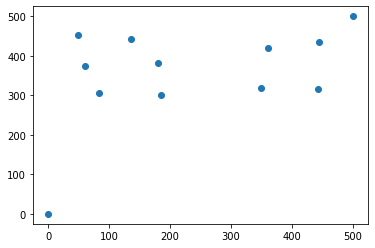

In [25]:
a =np.array([
                [0, 0], [500, 500],
    [ 360.4642650342118, 419.3875532142838 ],
      [ 442.27935834144193, 315.51471627106577 ],
      [ 184.94846778195537, 301.4503505948413 ],
      [ 444.67073445403076, 435.3057739952226 ],
      [ 49.46432345195794, 451.45525768064374 ],
      [ 349.58635071433946, 318.01619823484594 ],
      [ 83.78248178801624, 305.3216204934017 ],
      [ 59.53154238549827, 374.7112528322925 ],
      [ 136.56060288371825, 443.3993917250272 ],
      [ 180.06470243737155, 380.74854128270164 ]
])

plt.scatter(a[:,0], a[:,1])